# Continuous Control

This notebook is the second project of Deep Reinforcement Learnig Nanodgree(@udacity).


 - Deep Deterministic Policy Gradient; Soft Updates and Replay buffer implemented in the Unity environment.
 - Please note that the code from the DDPG lecture was used as the source.

All you have to do is run the code cells one by one. You'll see an untrained agent become an expert.

### 1. Start the Environment

In [1]:
import random
import time
import copy
import numpy as np
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

Sure you like Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

This notebook placed in the same folder as *'recheacher.exe'* runs fine on **windows10**. It can't be guaranteed the nice results on other operating systems.

Let's start the Environment!

In [3]:
env = UnityEnvironment(file_name="Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Let's make the first ***brain*** available, and set it as the default one.

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In [6]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores = np.zeros(num_agents)
for i in range(100):
    actions = np.random.randn(num_agents, action_size)
    actions = np.clip(actions, -1, 1)
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += env_info.rewards
    states = next_states
    if np.any(dones):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### 4. Actor Critic Network
There are two classes in following code cell

 - Actor: states -> actions
 - Critic : state and action -> Q-values.

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):   

    def __init__(self, state_size, action_size, seed, fc1_units=320, fc2_units=160):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        # Batch Nomalization
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn3 = nn.BatchNorm1d(action_size)
        # reset paramters
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):        
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        return F.tanh(self.bn3(self.fc3(x)))


class Critic(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fcs1_units=320, fc2_units=160):  
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)        
        self.fc3 = nn.Linear(fc2_units, 1)
        # reset paramters
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):        
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        
        return self.fc3(x)

### 5. Replay Buffer

In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):        
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

### 6. Noisy process

In [9]:
class OUNoise:
    
    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):    
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

### 7. DDPG Agent

In [10]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4
LR_CRITIC = 1e-4
WEIGHT_DECAY = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DDPG_agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
                
        self.actor_local = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        self.critic_local = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.noise = OUNoise((num_agents,action_size), random_seed)
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)       
        
    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()       
        
        return np.clip(action, -1, 1)
        
    def step(self, state, action, reward, next_state, done):
        for i in range(state.shape[0]):
            self.memory.add(state[i, :], action[i], reward[i], next_state[i, :], done[i])
                
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
        
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 8. Training

In [11]:
agents = DDPG_agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

def DDPG(n_episodes=500, max_t=1000):
    scores_deque = deque(maxlen=100)
    print_every = 10
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
       
        for t in range(max_t):
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                print('\tSteps: ', t)
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.format(i_episode, 
                                                                          np.mean(scores_deque), 
                                                                          np.mean(score)))
        average_score = np.mean(scores_deque)
        if i_episode % print_every == 20 or average_score > 30:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth') 
            if average_score > 30:
                break
    return scores

Finally, training begins.

In [12]:
score = DDPG()

C:\Users\user\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: 0.48	Score: 0.482
Episode 2	Average Score: 0.58	Score: 0.676
Episode 3	Average Score: 0.71	Score: 0.967
Episode 4	Average Score: 0.76	Score: 0.921
Episode 5	Average Score: 0.77	Score: 0.822
Episode 6	Average Score: 0.81	Score: 0.995
Episode 7	Average Score: 0.90	Score: 1.417
Episode 8	Average Score: 1.02	Score: 1.899
Episode 9	Average Score: 1.18	Score: 2.473
Episode 10	Average Score: 1.34	Score: 2.729
Episode 11	Average Score: 1.53	Score: 3.455
Episode 12	Average Score: 1.77	Score: 4.423
Episode 13	Average Score: 2.05	Score: 5.398
Episode 14	Average Score: 2.30	Score: 5.542
Episode 15	Average Score: 2.66	Score: 7.745
Episode 16	Average Score: 3.07	Score: 9.139
Episode 17	Average Score: 3.48	Score: 10.079
Episode 18	Average Score: 4.10	Score: 14.545
Episode 19	Average Score: 4.67	Score: 14.925
Episode 20	Average Score: 5.47	Score: 20.694
Episode 21	Average Score: 6.20	Score: 20.784
Episode 22	Average Score: 7.10	Score: 26.124
Episode 23	Average Score: 8.15	Scor

Enjoy the beautiful rising curves.

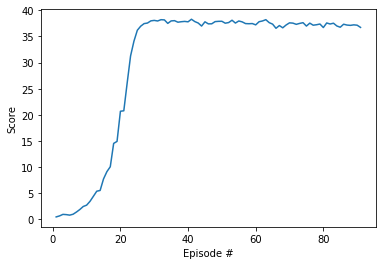

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score)+1), score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 9. Let's look at the smart agent we trained
It is stored in *Checkpoint_xx.pth* trained weights. Let's load this file now.

In [14]:
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          

for i in range(200):
    actions = agents.act(states, add_noise=False)                    
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    scores += rewards                         
    states = next_states                              
    if np.any(dones):                              
        break

In [15]:
env.close()

### 10. Result

- Targeted Average Scores reached  within 91 episodes.
- Batch Nomalization help to speed up a bit

Thank you